In [21]:
import pickle
import numpy as np
from sklearn.preprocessing import RobustScaler,MinMaxScaler
X_ppg,X_qual,X_acc,y_rr,y_respiration,y_inspiration,y_expiration,groups,X_respiration,y_activity,y_label = pickle.load(open('../../affect-recognition/data/tabular_data_8.p','rb'))

In [22]:
import matplotlib.pyplot as plt
X_fft = np.fft.fft(X_acc[:,:,:],axis=1,n=512)
plt.plot(X_fft[0][:,0])
plt.plot(np.arange(0,256),X_fft[0][:256,0])
plt.plot(np.arange(256,512),X_fft[0][:256,0][::-1]*-1)
# plt.plot(X_fft[0][256:,0])
plt.show()

In [23]:
from sklearn.preprocessing import OneHotEncoder
index = np.where((y_activity!=0)&(y_activity!=3)&(y_activity!=6)&(y_activity!=8))[0]
X_acc = X_acc[index]
y_activity = y_activity[index]
groups = groups[index]
y_activity = OneHotEncoder().fit_transform(y_activity.reshape(-1,1)).todense()
X_fft = np.fft.fft(X_acc[:,:,:],axis=1,n=512)[:,:256,:]
X_fft_real = X_fft.real
X_fft_imag = X_fft.imag
X_fft = np.concatenate([X_fft_real,X_fft_imag],axis=2)

/home/azim/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [24]:
# X_fft = np.concatenate([X_acc]*2,axis=2)
max_value = X_fft.max()
X_fft = X_fft/max_value
X_fft.shape,y_activity.shape


((22832, 256, 6), (22832, 5))

In [25]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms,datasets
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchsummary import summary
import torch.utils.data as data_utils
batch_size = 256
train = data_utils.TensorDataset(torch.from_numpy(X_fft), torch.from_numpy(y_activity.reshape(-1,1,5)))
data_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

In [26]:
class Generator(nn.Module): 
    def __init__(self):
        super(Generator, self).__init__()
        self.n_classes = 5
        self.std = .002
        self.output_length = 256*6
        self.noise_length = 100
        self.intermediate_length = 800
        self.n_channels = 6
        self.n_timesteps = 256
        self.model_noise = nn.Sequential(
            nn.Linear(self.noise_length,self.n_timesteps*self.noise_length//10),
            nn.Tanh()
        )
        self.model_noise2 = nn.Sequential(
            nn.Conv1d(10,self.n_timesteps,kernel_size=10),
            nn.Tanh()
        )
        
        self.model_label = nn.Sequential(
            nn.Linear(self.n_classes,self.n_timesteps),
            nn.ReLU()
        )
        self.model_label2 = nn.Sequential(
            nn.Conv1d(1,self.n_timesteps,kernel_size=10),
            nn.ReLU()
        )
        
        self.model_final = nn.Sequential(
            nn.Conv1d(494,100,kernel_size=10),
            nn.Tanh(),
            nn.Conv1d(100,100,kernel_size=5),
            nn.Tanh(),
            nn.Conv1d(100,6,kernel_size=4,padding=8),
            nn.Tanh()
            
            
        )
        
    def forward(self, noise, labels): 
#         noise = noise + torch.randn(noise/.size()).cuda() * self.std
#         labels = labels + torch.randn(labels.size()).cuda() * self.std
        labels = labels.view(labels.size(0),self.n_classes)
        labels = self.model_label(labels.float())
        labels = labels.view(labels.size(0),1,self.n_timesteps)
        labels = self.model_label2(labels)
        noise = noise.view(noise.size(0),self.noise_length)
        noise = self.model_noise(noise)
        noise = noise.view(noise.size(0),10,self.n_timesteps)
        noise = self.model_noise2(noise)
        intermediate_data = torch.cat([noise,labels],2)
        intermediate_data = intermediate_data.view(-1,494,self.n_timesteps)
        intermediate_data = self.model_final(intermediate_data)
        intermediate_data = intermediate_data.view(-1,self.n_timesteps,self.n_channels)
        return intermediate_data
    
    
class Discriminator(nn.Module): 
    def __init__(self): 
        super(Discriminator, self).__init__()
        self.n_classes = 5
        self.std = .002
        self.output_length = 1
        self.noise_length = 100
        self.intermediate_length = 800
        self.n_channels = 6
        self.n_timesteps = 256
        self.input_length = 256*6
        self.model_label = nn.Sequential(
            nn.Linear(self.n_classes,self.n_channels*self.n_timesteps)
        )
        self.model_final = nn.Sequential(
            nn.Conv1d(12,100,kernel_size=4,padding_mode='replicate',padding=1),
            nn.Tanh(),
            nn.MaxPool1d(2),
            nn.Conv1d(100,100,kernel_size=8,padding_mode='replicate',padding=4),
            nn.Tanh(),
            nn.MaxPool1d(4),
            nn.Conv1d(100,100,kernel_size=8,padding_mode='replicate',padding=4),
            nn.Tanh(),
            nn.MaxPool1d(8),
            nn.Flatten(),
            nn.Linear(400,10),
            nn.Sigmoid(),
            nn.Linear(10,1),
            nn.Sigmoid()
        )
    def forward(self, img, labels): 
        labels = labels + torch.randn(labels.size()).cuda() * self.std
        labels = labels.view(labels.size(0),self.n_classes)
        labels = self.model_label(labels.float())
        img = img.view(img.size(0),self.n_channels,self.n_timesteps)
        labels = labels.view(labels.size(0),self.n_channels,self.n_timesteps)
        intermediate_data = torch.cat([img,labels],1)
        intermediate_data = self.model_final(intermediate_data)
        return intermediate_data
 


In [27]:
# weight initialization
def init_weights(model):
    if type(model) in [nn.Linear]:
        nn.init.xavier_uniform_(model.weight)
        nn.init.zeros_(model.bias)
    elif type(model) in [nn.LSTM, nn.RNN, nn.GRU]:
        nn.init.orthogonal_(model.weight_hh_l0)
        nn.init.xavier_uniform_(model.weight_ih_l0)
        nn.init.zeros_(model.bias_hh_l0)
        nn.init.zeros_(model.bias_ih_l0)

lrate = .002
beta = .5
beta1 = .99
# Building generator 
generator = Generator()
generator.apply(init_weights)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lrate, betas=(beta,beta1))

# Building discriminator  
discriminator = Discriminator()
discriminator.apply(init_weights)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lrate, betas=(beta,beta1))

In [28]:
a_loss = torch.nn.BCELoss()

real_label = 0.001
fake_label = .999

FT = torch.LongTensor
FT_a = torch.FloatTensor

cuda = True if torch.cuda.is_available() else False 
if cuda: 
    print(1)
    generator.cuda()
    discriminator.cuda()
    a_loss.cuda()

1


EPOCH = 0


/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


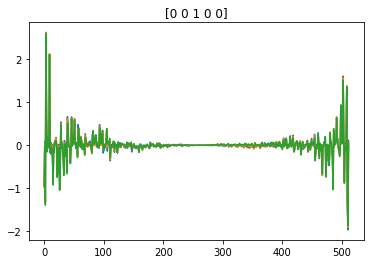

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


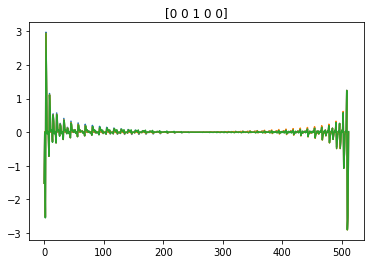

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


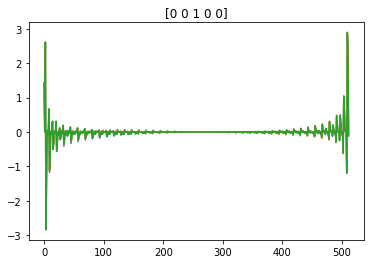

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


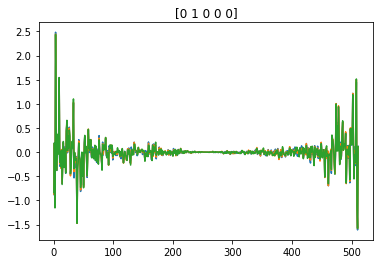

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


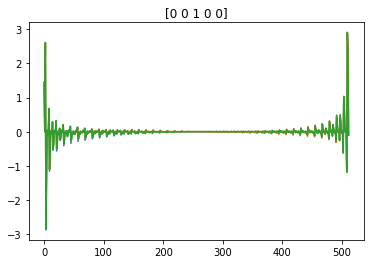

EPOCH = 1
EPOCH = 2
EPOCH = 3
EPOCH = 4
EPOCH = 5
EPOCH = 6
EPOCH = 7
EPOCH = 8
EPOCH = 9
EPOCH = 10


/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


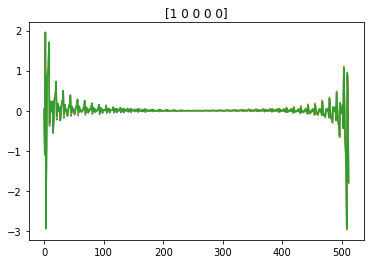

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


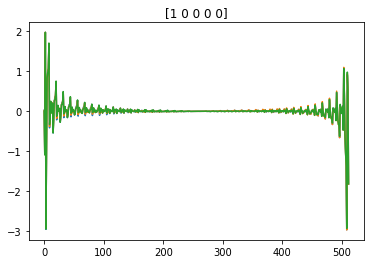

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


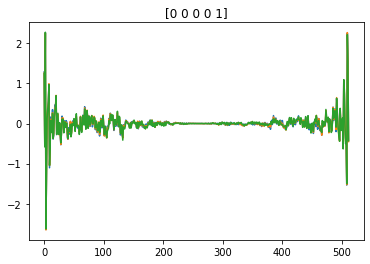

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


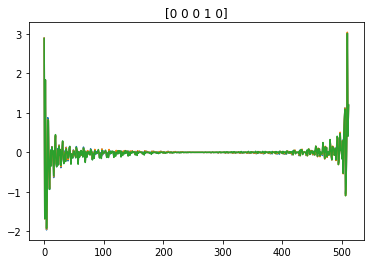

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


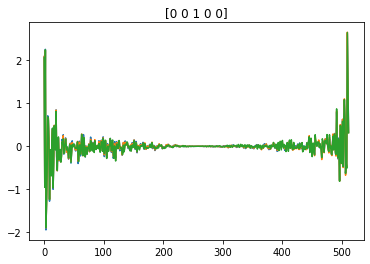

EPOCH = 11
EPOCH = 12
EPOCH = 13
EPOCH = 14
EPOCH = 15
EPOCH = 16
EPOCH = 17
EPOCH = 18
EPOCH = 19
EPOCH = 20


/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


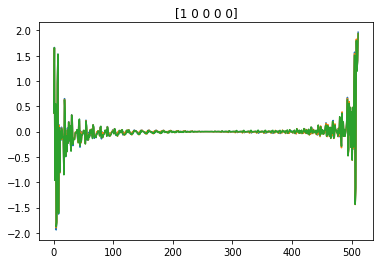

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


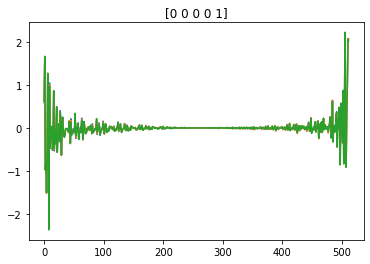

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


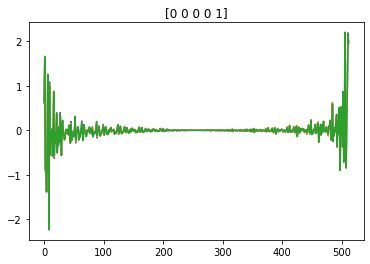

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


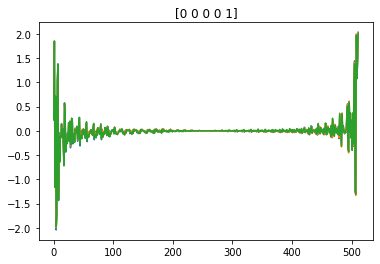

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


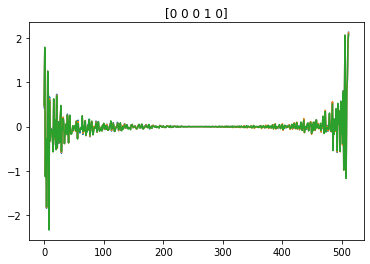

EPOCH = 21
EPOCH = 22
EPOCH = 23
EPOCH = 24
EPOCH = 25
EPOCH = 26
EPOCH = 27
EPOCH = 28
EPOCH = 29
EPOCH = 30


/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


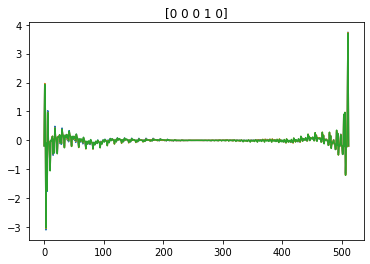

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


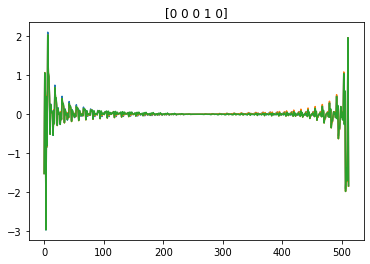

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


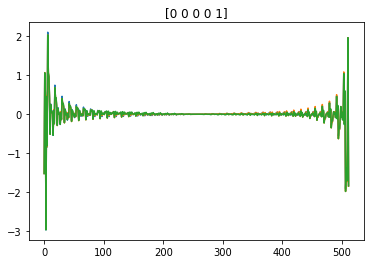

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


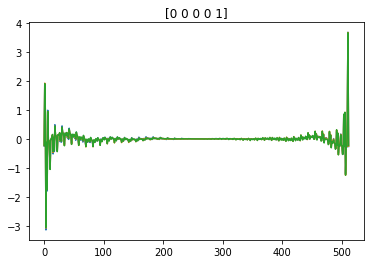

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


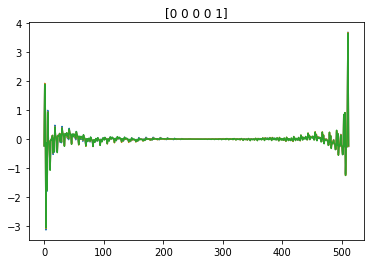

EPOCH = 31
EPOCH = 32
EPOCH = 33
EPOCH = 34
EPOCH = 35
EPOCH = 36
EPOCH = 37
EPOCH = 38
EPOCH = 39
EPOCH = 40


/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


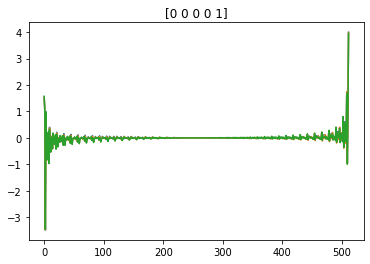

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


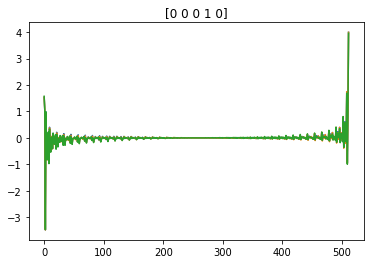

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


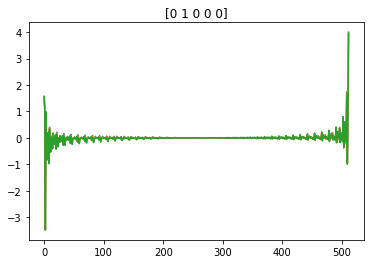

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


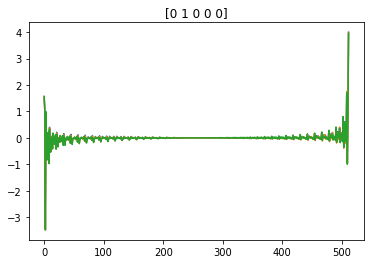

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


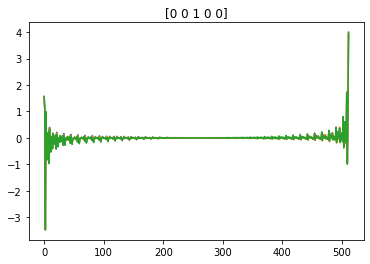

EPOCH = 41
EPOCH = 42
EPOCH = 43
EPOCH = 44
EPOCH = 45
EPOCH = 46
EPOCH = 47
EPOCH = 48
EPOCH = 49
EPOCH = 50


/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


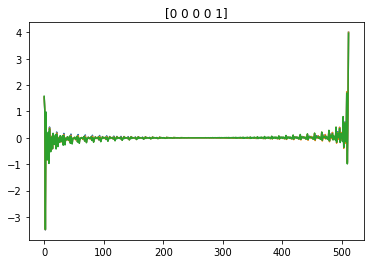

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


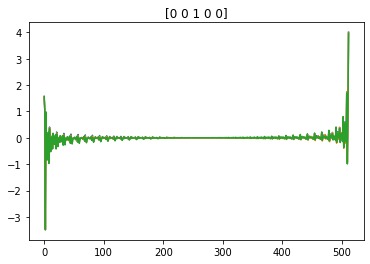

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


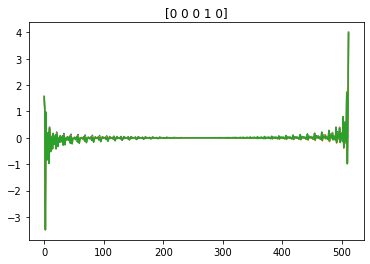

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


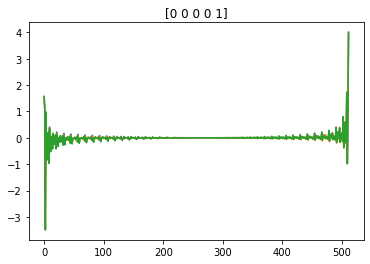

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


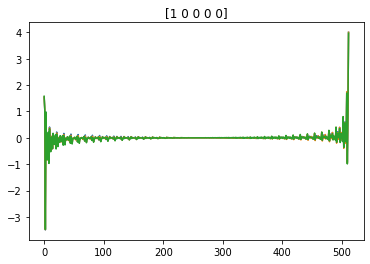

EPOCH = 51
EPOCH = 52
EPOCH = 53
EPOCH = 54
EPOCH = 55
EPOCH = 56
EPOCH = 57
EPOCH = 58


KeyboardInterrupt: 

In [46]:
latentdim = 100
n_classes = 5
epochs = 300
def get_fake_labels(n=n_classes,s=batch_size):
    a = np.random.randint(0, n, s)
    b = np.zeros((a.size, n))
    b[np.arange(a.size),a] = 1
    return b

for epoch in range(epochs): 
    print('EPOCH =',epoch)
    for i, (imgs, labels) in enumerate(data_loader): 
        batch_size = imgs.shape[0]

        # convert img, labels into proper form 
        imgs = Variable(imgs.type(FT_a)).cuda()
        labels = Variable(labels.type(FT)).cuda()

        # creating real and fake tensors of labels 
        reall = Variable(FT_a(batch_size,1).fill_(real_label)).cuda()
        f_label = Variable(FT_a(batch_size,1).fill_(fake_label)).cuda()

        # initializing gradient
        gen_optimizer.zero_grad() 
        d_optimizer.zero_grad()

        #### TRAINING GENERATOR ####
        # Feeding generator noise and labels 
        noise = Variable(FT_a(np.random.normal(10, 100,(batch_size, latentdim)))).cuda()
        gen_labels = Variable(FT(get_fake_labels(n_classes,batch_size))).cuda()
        gen_imgs = generator(noise, gen_labels)
        validity = discriminator(gen_imgs, gen_labels)
#         all_params = torch.cat([x.view(-1) for x in gen_imgs])
#         l1_regularization = torch.norm(all_params, 2)
        g_loss = a_loss(validity, reall) 
        g_loss.backward()
        gen_optimizer.step()
        
        d_optimizer.zero_grad()

        # Loss for real images and labels 
        validity_real = discriminator(imgs, labels)
        
        d_real_loss = a_loss(validity_real, reall)

        # Loss for fake images and labels 
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = a_loss(validity_fake, f_label)

        # Total discriminator loss 
        d_loss = 0.5 * (d_fake_loss+d_real_loss)

        # calculates discriminator gradients
        d_loss.backward()
        d_optimizer.step()
        
        if i%100 == 0 and epoch%10==0: 
            fake = generator(noise, gen_labels).detach().cpu().numpy()*max_value
            labels_cpu = gen_labels.detach().cpu().numpy()
            x_pred_real = fake[:,:,:3]
            x_pred_imag = fake[:,:,3:]

            x_pred_real = np.concatenate([x_pred_real,x_pred_real[:,::-1,:]],axis=1)
            x_pred_imag = np.concatenate([x_pred_imag,-1*x_pred_imag[:,::-1,:]],axis=1)
            x_pred = x_pred_real+1j*x_pred_imag
            for k in range(5):
                plt.figure()
                plt.plot(np.fft.ifft(x_pred[k][:,0],n=512))
                plt.plot(np.fft.ifft(x_pred[k][:,1],n=512))
                plt.plot(np.fft.ifft(x_pred[k][:,2],n=512))
                
#                 plt.show()
#                 plt.figure()
#                 plt.plot(np.fft.ifft(x_pred[k][:,0]+1j*x_pred[k][:,3]))
#                 plt.plot(np.fft.ifft(x_pred[k][:,1]+1j*x_pred[k][:,4]))
#                 plt.plot(np.fft.ifft(x_pred[k][:,2]+1j*x_pred[k][:,5]))
                plt.title(labels_cpu[k])
                plt.show()

In [43]:
fake = generator(noise, gen_labels).detach().cpu().numpy()*max_value
labels_cpu = gen_labels.detach().cpu().numpy()
x_pred_real = fake[:,:,:3]
x_pred_imag = fake[:,:,3:]

x_pred_real = np.concatenate([x_pred_real,x_pred_real[:,::-1,:]],axis=1)
x_pred_imag = np.concatenate([x_pred_imag,-1*x_pred_imag[:,::-1,:]],axis=1)

In [44]:
x_pred = x_pred_real+1j*x_pred_imag

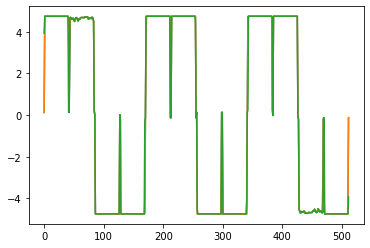

In [45]:
plt.plot(x_pred_imag[0])